# Snorkel for Place of Birth Relation Extraction

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from snorkel import SnorkelSession
session = SnorkelSession()

## Preprocessing corpus

We use a `TSVDocPreprocessor` to load documents into a local Sqlite3 session.

In [2]:
from snorkel.parser import TSVDocPreprocessor
from snorkel.parser.spacy_parser import Spacy
from snorkel.parser import CorpusParser

doc_preprocessor = TSVDocPreprocessor('data/pob_100.tsv', max_docs=100)
corpus_parser = CorpusParser(parser=Spacy())
%time corpus_parser.apply(doc_preprocessor, parallelism=1)

Clearing existing...
Running UDF...
CPU times: user 1.06 s, sys: 25.6 ms, total: 1.09 s
Wall time: 1.1 s


Verifying our documents exist:

In [3]:
from snorkel.models import Document, Sentence

print("Documents:", session.query(Document).count())
print("Sentences:", session.query(Sentence).count())

Documents: 96
Sentences: 325


## Generating Candidates

NER on places is hard. To make it easier, we'll use a dataset of cities/subcountries/countries from geonames. To get it, run

```bash
cd data
python download_locs.py
```

In [4]:
with open('data/locs.txt', 'r') as fin:
    locs = {loc.strip(): True for loc in fin}

In [5]:
from snorkel.models import candidate_subclass
from snorkel.candidates import Ngrams, CandidateExtractor
from snorkel.matchers import PersonMatcher, LocationMatcher, DictionaryMatch, LambdaFunctionMatcher

PlaceOfBirth = candidate_subclass('PlaceOfBirth', ['person', 'pob'])

ngrams = Ngrams(n_max=7)
person_matcher = PersonMatcher(longest_match_only=True)
location_matcher = DictionaryMatch(d=locs, ignore_case=False, longest_match_only=True)

cand_extractor = CandidateExtractor(PlaceOfBirth, 
                                    [ngrams, ngrams], [person_matcher, location_matcher],
                                    symmetric_relations=False)

In [6]:
from snorkel.models import Document
import random

# Set seed for reproducibility
random.seed(100)

docs = session.query(Document).order_by(Document.name).all()
random.shuffle(docs)

train_sents = set()
dev_sents = set()
test_sents = set()

for i, doc in enumerate(docs):
    for s in doc.sentences:
        if i % 10 == 8:
            dev_sents.add(s)
        elif i % 10 == 9:
            test_sents.add(s)
        else:
            train_sents.add(s)

In [7]:
for k, sents in enumerate([train_sents, dev_sents, test_sents]):
    cand_extractor.apply(sents, split=k)
    print("Number of candidates:", session.query(PlaceOfBirth).filter(PlaceOfBirth.split == k).count())

Clearing existing...
Running UDF...
[========================================] 100%

Number of candidates: 313
Clearing existing...
Running UDF...
[========================================] 100%

Number of candidates: 34
Clearing existing...
Running UDF...
[========================================] 100%

Number of candidates: 20


## Data Exploration

Now we view some of the candidates in the training set with `SentenceNGramViewer`:

In [8]:
import os
from snorkel.viewer import SentenceNgramViewer

train_cands = session.query(PlaceOfBirth).filter(PlaceOfBirth.split == 0).all()

SentenceNgramViewer(train_cands[:500], session, n_per_page=1)

<IPython.core.display.Javascript object>

SentenceNgramViewer(cids=[[[87, 88]], [[80, 181]], [[31, 32, 33, 34]], [[89, 90]], [[2, 3]], [[196]], [[77, 78, 79]], [[297, 298]], [[92]], [[30]], [[163]], [[278, 279]], [[280, 281]], [[56]], [[107, 108]], [[282, 283]], [[16, 17]], [[73, 74]], [[41, 42, 43, 44]], [[97]], [[179, 180, 206, 207, 256, 257]], [[109, 110, 151]], [[20, 21]], [[8, 9]], [[48, 49, 50, 144, 145, 146]], [[102]], [[269]], [[197]], [[168, 183]], [[53, 54, 149, 150]], [[11, 12, 13]], [[86]], [[289, 290, 291, 299, 300, 302, 303, 304, 307, 308]], [[305, 306, 309, 310, 311, 312]], [[96]], [[175, 176, 177, 178, 221, 222, 223, 224, 275, 276, 277]], [[143]], [[91]], [[247]], [[18, 19]], [[127, 128, 129, 130]], [[93, 94, 95]], [[55]], [[231, 232, 233]], [[51, 52, 111, 112]], [[0, 1]], [[220]], [[38, 39, 40, 169, 170, 171]], [[62, 63, 64, 103, 104, 105, 140, 141, 142, 165, 166, 167]], [[114, 115, 116]], [[45]], [[117]], [[81, 82, 253]], [[25]], [[7]], [[60, 61]], [[15]], [[119]], [[173, 174, 202, 203]], [[28, 29]], [[14]], [[131, 132, 133, 134]], [[294, 295, 296]], [[100, 101]], [[85]], [[98, 99, 147, 148]], [[46, 47, 263, 264, 287, 288]], [[198]], [[70, 260]], [[199, 200, 201, 218, 219, 234, 235, 236]], [[217]], [[106]], [[118]], [[225, 252]], [[208, 209, 210, 211, 248, 249, 250, 251, 270, 271, 272, 273, 274]], [[71, 72]], [[83, 84]], [[36, 37, 172]], [[284, 285, 286]], [[135]], [[65, 66, 67, 68, 69, 136, 137, 138, 139, 186, 187, 188, 189, 190, 191, 226, 227, 228, 229, 230]], [[243, 292, 293]], [[57, 58, 59, 157, 158, 159, 265, 266]], [[244]], [[26, 27, 258, 259]], [[113]], [[164, 182]], [[254, 255, 301]], [[4, 5, 6, 160, 161, 162, 237, 238]], [[216, 241, 242, 261, 262]], [[35, 267, 268]], [[204, 205]], [[24]], [[22, 23]], [[10]], [[192, 193, 194, 195, 212, 213, 214, 215]], [[75, 76]], [[245, 246]], [[154, 155, 156]], [[152, 153, 184, 185, 239, 240]], [[120, 121, 122, 123, 124, 125, 126]]], html='<head>\n<style>\nspan.candidate {\n    background-color: rgba(255,255,0,0.3);\n}\n\nspan.candidate-h {\n    background-color: rgba(255,255,0,1.0);\n}\n\nspan.true-candidate {\n    background-color: rgba(92,184,92,0.3);\n}\n\nspan.true-candidate-h {\n    background-color: rgba(92,184,92,1.0);\n}\n\nspan.false-candidate {\n    background-color: rgba(169,68,66,0.3);\n}\n\nspan.false-candidate-h {\n    background-color: rgba(169,68,66,1.0);\n}\n\nspan.highlighted {\n    font-weight: bolder;\n    box-shadow: 1px 1px 1px grey;\n}\n\nspan.left-candidate {\n    color: red;\n}\n\nspan.right-candidate {\n    color: blue;\n}\n\nspan.gold-annotation {\n    color: red;\n}\n\nspan.highlighted-gold-annotation {\n    background-color: rgba(217,83,79,0.5);\n}\n\n.panel-heading {\n    position: relative;\n}\n\n.panel-footer {\n    position: relative;\n}\n\n.panel-left-justify {\n    position: absolute;\n    right: 15px;\n    top: 20px;\n}\n\n.viewer-page {\n    display: none;\n}\n\n.help-text {\n    color: gray;\n    font-weight: 300;\n}\n</style>\n</head>\n\n<div id="viewer" class="viewer-pane panel panel-default" tabindex="0">\n    <div class="panel-heading">\n        <h3 class="panel-title"><i class="fa fa-eye fa-lg" aria-hidden="true"></i> Viewer</h3>\n        <div id="candidate-caption" class="panel-left-justify"></div>\n    </div>\n    <div class="panel-body" style="height:225px">\n<div class="viewer-page" id="viewer-page-0" style="display: block;">\n    <ul class="list-group">\n<li class="list-group-item" data-toggle="tooltip" data-placement="top" title="97"><span class="candidate 87 88 87-0 88-0">Morris Smith Miller</span><span class=""> (July 31, 1779 -- November 16, 1824) was a </span><span class="candidate 87 87-1">United States</span><span class=""> Representative from </span><span class="candidate 88 88-1">New York</span><span class="">.</span></li>\n</ul>\n</div>\n\n<div class="viewer-page" id="viewer-page-1">\n    <ul class="list-group">\n<li class="list-group-item" data-toggle="tooltip" data-placement="top" title="100"><span class="candidate 80 80-0">Miller</span><span clas

## Labeling functions

In [9]:
from snorkel.lf_helpers import (
    get_left_tokens, get_right_tokens, get_between_tokens,
    get_text_between, get_tagged_text,
)

# Function to get candidates labeled
def get_labeled_candidates(lf, split=0):
    labeled = []
    for c in session.query(PlaceOfBirth).filter(PlaceOfBirth.split == split).all():
        if lf(c) != 0:
            labeled.append(c)
    return labeled

/Users/jayelm/.virtualenvs/snorkel/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


First, let's try an easy labeling function: checking to see if the world *born* exists between the person and the place. We'll do the same for the word *from*

In [157]:
def LF_born_between(c):
    return 1 if 'born' in get_between_tokens(c) else 0

def LF_from_between(c):
    return 1 if 'from' in get_between_tokens(c) else 0

labeled = get_labeled_candidates(LF_born_between, split=0)
SentenceNgramViewer(labeled, session, n_per_page=1)

<IPython.core.display.Javascript object>

SentenceNgramViewer(cids=[[[59, 60]], [[2, 3]], [[53, 54, 55]], [[24]], [[38]], [[15, 16]], [[49, 50]], [[8, 9]], [[30, 31, 32]], [[35, 36, 73, 74]], [[11, 12, 13]], [[58]], [[65]], [[61]], [[62, 63, 64]], [[37]], [[33, 34]], [[0, 1]], [[41, 42, 43, 66, 67, 68, 70, 71, 72, 75, 76, 77]], [[19]], [[7]], [[39, 40]], [[14]], [[22, 23]], [[28, 29]], [[56, 57]], [[26, 27]], [[44, 45, 46, 47, 48, 69, 78, 79]], [[20, 21]], [[4, 5, 6]], [[25, 80]], [[17, 18]], [[10]], [[51, 52]]], html='<head>\n<style>\nspan.candidate {\n    background-color: rgba(255,255,0,0.3);\n}\n\nspan.candidate-h {\n    background-color: rgba(255,255,0,1.0);\n}\n\nspan.true-candidate {\n    background-color: rgba(92,184,92,0.3);\n}\n\nspan.true-candidate-h {\n    background-color: rgba(92,184,92,1.0);\n}\n\nspan.false-candidate {\n    background-color: rgba(169,68,66,0.3);\n}\n\nspan.false-candidate-h {\n    background-color: rgba(169,68,66,1.0);\n}\n\nspan.highlighted {\n    font-weight: bolder;\n    box-shadow: 1px 1px 1px grey;\n}\n\nspan.left-candidate {\n    color: red;\n}\n\nspan.right-candidate {\n    color: blue;\n}\n\nspan.gold-annotation {\n    color: red;\n}\n\nspan.highlighted-gold-annotation {\n    background-color: rgba(217,83,79,0.5);\n}\n\n.panel-heading {\n    position: relative;\n}\n\n.panel-footer {\n    position: relative;\n}\n\n.panel-left-justify {\n    position: absolute;\n    right: 15px;\n    top: 20px;\n}\n\n.viewer-page {\n    display: none;\n}\n\n.help-text {\n    color: gray;\n    font-weight: 300;\n}\n</style>\n</head>\n\n<div id="viewer" class="viewer-pane panel panel-default" tabindex="0">\n    <div class="panel-heading">\n        <h3 class="panel-title"><i class="fa fa-eye fa-lg" aria-hidden="true"></i> Viewer</h3>\n        <div id="candidate-caption" class="panel-left-justify"></div>\n    </div>\n    <div class="panel-body" style="height:225px">\n<div class="viewer-page" id="viewer-page-0" style="display: block;">\n    <ul class="list-group">\n<li class="list-group-item" data-toggle="tooltip" data-placement="top" title="107"><span class="candidate 59 60 59-0 60-0">Juan Laporte</span><span class=""> (born November 24, 1959) is a former boxer who was born in </span><span class="candidate 60 60-1">Guayama</span><span class="">, </span><span class="candidate 59 59-1">Puerto Rico</span><span class="">.\n</span></li>\n</ul>\n</div>\n\n<div class="viewer-page" id="viewer-page-1">\n    <ul class="list-group">\n<li class="list-group-item" data-toggle="tooltip" data-placement="top" title="108"><span class="candidate 2 3 2-0 3-0">Muhammad Tulaimat</span><span class=""> (محمد طليمات) (born 1941) is a modernist painter from the city of </span><span class="candidate 3 3-1">Homs</span><span class="">, </span><span class="candidate 2 2-1">Syria</span><span class="">.</span></li>\n</ul>\n</div>\n\n<div class="viewer-page" id="viewer-page-2">\n    <ul class="list-group">\n<li class="list-group-item" data-toggle="tooltip" data-placement="top" title="119"><span class="candidate 53 54 55 53-0 54-0 55-0">Angus Mackay</span><span class="">, born in </span><span class="candidate 55 55-1">Lima</span><span class="">, </span><span class="candidate 53 53-1">Peru</span><span class=""> in 1939, is a Scottish historian and Hispanist, specialising in Later Medieval </span><span class="candidate 54 54-1">Spain</span><span class="">.\n</span></li>\n</ul>\n</div>\n\n<div class="viewer-page" id="viewer-page-3">\n    <ul class="list-group">\n<li class="list-group-item" data-toggle="tooltip" data-placement="top" title="123"><span class="candidate 24 24-0">Lezana</span><span class=""> was born at </span><span class="candidate 24 24-1">Madrid</span><span class="">.</span></li>\n</ul>\n</div>\n\n<div class="viewer-page" id="viewer-page-4">\n    <ul class="list-group">\n<li class="list-group-item" data-toggle="tooltip" data-placement="top" title="132"><span class="candidate 38 38-0">Ana Luiza Nobre</span><span class=""> is a Brazilian architectural historian, author and 

After viewing NGrams, it's clear that since the location tagger tags cities and states, both are labeled. However, in our dataset, we generally prefer the most specific location, so we write additional labeling functions that return False if there is another location closer to the person

In [159]:
def span_is_pob(span):
    return bool(span.place_of_birth_pobs)

def span_is_person(span):
    return bool(span.place_of_birth_persons)

def span_distance(s1, s2):
    s1_start, s1_end = s1.get_word_start(), s1.get_word_end()
    s2_start, s2_end = s2.get_word_start(), s2.get_word_end()
    if s2_start < s1_start:
        return s1_start - s2_end
    else:
        return s2_start - s1_end

# TODO: Don't count less-specific substrings e.g. killing "Washington D.C." in favor of "Washington"
def LF_closer_pob(c):
    # Get distance between person and pob
    cand_distance = span_distance(c.person, c.pob)
    sent = c.get_parent()
    other_pobs = [span for span in sent.get_children()
                  if (span != c.person) and (span != c.pob) and (span_is_pob(span))]
    for other_pob in other_pobs:
        if span_distance(c.person, other_pob) < cand_distance:
            return -1
    return 0

labeled = get_labeled_candidates(LF_closer_pob, split=0)
SentenceNgramViewer(labeled, session, n_per_page=1)

<IPython.core.display.Javascript object>

SentenceNgramViewer(cids=[[[45]], [[13, 14, 15]], [[46]], [[1]], [[41, 42]], [[171]], [[160]], [[161]], [[53]], [[162]], [[7]], [[39]], [[20, 21, 22]], [[97, 113, 146]], [[54, 55, 80]], [[9]], [[4]], [[24, 25, 76, 77]], [[27, 79]], [[5, 6]], [[166, 167, 172, 173, 174, 175, 177, 178]], [[176, 179, 180]], [[94, 95, 96, 124, 125, 126, 157, 158, 159]], [[8]], [[65, 66, 67]], [[47, 48]], [[131, 132]], [[26, 56]], [[0]], [[18, 19, 91, 92]], [[31, 32, 51, 52, 74, 75, 89, 90]], [[57, 58]], [[43, 144]], [[30]], [[93, 110, 111]], [[12]], [[68, 69, 70]], [[169, 170]], [[50]], [[49, 78]], [[23, 149, 165]], [[108, 109, 122, 123, 133, 134]], [[114, 115, 116, 140, 141, 142, 143, 153, 154, 155, 156]], [[38]], [[44]], [[17]], [[163, 164]], [[33, 34, 35, 36, 37, 71, 72, 73, 99, 100, 101, 102, 103, 127, 128, 129, 130]], [[168]], [[28, 29, 84, 85, 86, 150, 151]], [[11, 147]], [[145]], [[2, 3, 87, 88, 135, 136]], [[121, 138, 148]], [[16, 152]], [[112]], [[10]], [[104, 105, 106, 107, 117, 118, 119, 120]], [[40]], [[139]], [[82, 83]], [[81, 98, 137]], [[59, 60, 61, 62, 63, 64]]], html='<head>\n<style>\nspan.candidate {\n    background-color: rgba(255,255,0,0.3);\n}\n\nspan.candidate-h {\n    background-color: rgba(255,255,0,1.0);\n}\n\nspan.true-candidate {\n    background-color: rgba(92,184,92,0.3);\n}\n\nspan.true-candidate-h {\n    background-color: rgba(92,184,92,1.0);\n}\n\nspan.false-candidate {\n    background-color: rgba(169,68,66,0.3);\n}\n\nspan.false-candidate-h {\n    background-color: rgba(169,68,66,1.0);\n}\n\nspan.highlighted {\n    font-weight: bolder;\n    box-shadow: 1px 1px 1px grey;\n}\n\nspan.left-candidate {\n    color: red;\n}\n\nspan.right-candidate {\n    color: blue;\n}\n\nspan.gold-annotation {\n    color: red;\n}\n\nspan.highlighted-gold-annotation {\n    background-color: rgba(217,83,79,0.5);\n}\n\n.panel-heading {\n    position: relative;\n}\n\n.panel-footer {\n    position: relative;\n}\n\n.panel-left-justify {\n    position: absolute;\n    right: 15px;\n    top: 20px;\n}\n\n.viewer-page {\n    display: none;\n}\n\n.help-text {\n    color: gray;\n    font-weight: 300;\n}\n</style>\n</head>\n\n<div id="viewer" class="viewer-pane panel panel-default" tabindex="0">\n    <div class="panel-heading">\n        <h3 class="panel-title"><i class="fa fa-eye fa-lg" aria-hidden="true"></i> Viewer</h3>\n        <div id="candidate-caption" class="panel-left-justify"></div>\n    </div>\n    <div class="panel-body" style="height:225px">\n<div class="viewer-page" id="viewer-page-0" style="display: block;">\n    <ul class="list-group">\n<li class="list-group-item" data-toggle="tooltip" data-placement="top" title="97"><span class="candidate 45 45-0">Morris Smith Miller</span><span class=""> (July 31, 1779 -- November 16, 1824) was a United States Representative from </span><span class="candidate 45 45-1">New York</span><span class="">.</span></li>\n</ul>\n</div>\n\n<div class="viewer-page" id="viewer-page-1">\n    <ul class="list-group">\n<li class="list-group-item" data-toggle="tooltip" data-placement="top" title="106"><span class="candidate 13 14 15 13-0 14-0 15-0">Jack Curtner</span><span class=""> (9 July 1888 Greenville, </span><span class="candidate 13 13-1">Ohio</span><span class=""> -- 1 January 1961 </span><span class="candidate 14 14-1">Dayton</span><span class="">, </span><span class="candidate 15 15-1">Ohio</span><span class="">) was an American racecar driver.\n</span></li>\n</ul>\n</div>\n\n<div class="viewer-page" id="viewer-page-2">\n    <ul class="list-group">\n<li class="list-group-item" data-toggle="tooltip" data-placement="top" title="107"><span class="candidate 46 46-0">Juan Laporte</span><span class=""> (born November 24, 1959) is a former boxer who was born in Guayama, </span><span class="candidate 46 46-1">Puerto Rico</span><span class="">.\n</span></li>\n</ul>\n</div>\n\n<div class="viewer-page" id="viewer-page-3">\n    <ul class="list-group">\n<li class="list-group-item" data-toggle="tooltip" data-placement="top"

We can also compose LFs together. Examples like

> Jack Curtner (9 July 1888 Greenville, Ohio -- 1 January 1961 Dayton, Ohio) was an American racecar driver.

suggest that some sentences in our dataset contain `born location -- death location` information immediately following a name. We can use parentheses as an explicit supervision signal. Specifically, if a `pob` is the leftmost `pob` in parentheses immediately following the person name, we vote yes.

In [160]:
def close_paren_right(c, window=20):
    """
    Simple heuristic for checking close parentheses.
    Note, doesn't account for nested parens
    """
    for token in get_right_tokens(c, window=window):
        if token == '(':
            return False
        if token == ')':
            return True
    return False

def open_paren_left(c, window=20):
    for token in list(get_left_tokens(c, window=window))[::-1]:
        if token == ')':
            return False
        if token == '(':
            return True
    return False

def surrounded_parens(c, window=20):
    return close_paren_right(c, window=window) and open_paren_left(c, window=window)

def paren_imm_right(c):
    """Is there a left paren immediately right of the person?"""
    return next(get_right_tokens(c, window=1)) == '('

def right_paren_index(c):
    return c.get_word_end() + 1

def left_paren_index(c, window=20):
    """Get the left paren index found by open_paren_left. Assumes open_paren_left returns True!"""
    for i, token in enumerate(list(get_left_tokens(c, window=window))[::-1]):
        if token == '(':
            return c.get_word_start() - (i + 1)
    raise RuntimeError("No left paren found")

def LF_leftmost_pob_in_parens(c):
    if not LF_closer_pob(c) and surrounded_parens(c.pob) and \
            paren_imm_right(c.person) and right_paren_index(c.person) == left_paren_index(c.pob):
        return 1
    return 0

labeled = get_labeled_candidates(LF_leftmost_pob_in_parens, split=0)
SentenceNgramViewer(labeled, session, n_per_page=1)

<IPython.core.display.Javascript object>

SentenceNgramViewer(cids=[[[4]], [[0]], [[8]], [[13]], [[14]], [[1]], [[6]], [[9]], [[3]], [[12]], [[7]], [[10]], [[11]], [[5]], [[2]]], html='<head>\n<style>\nspan.candidate {\n    background-color: rgba(255,255,0,0.3);\n}\n\nspan.candidate-h {\n    background-color: rgba(255,255,0,1.0);\n}\n\nspan.true-candidate {\n    background-color: rgba(92,184,92,0.3);\n}\n\nspan.true-candidate-h {\n    background-color: rgba(92,184,92,1.0);\n}\n\nspan.false-candidate {\n    background-color: rgba(169,68,66,0.3);\n}\n\nspan.false-candidate-h {\n    background-color: rgba(169,68,66,1.0);\n}\n\nspan.highlighted {\n    font-weight: bolder;\n    box-shadow: 1px 1px 1px grey;\n}\n\nspan.left-candidate {\n    color: red;\n}\n\nspan.right-candidate {\n    color: blue;\n}\n\nspan.gold-annotation {\n    color: red;\n}\n\nspan.highlighted-gold-annotation {\n    background-color: rgba(217,83,79,0.5);\n}\n\n.panel-heading {\n    position: relative;\n}\n\n.panel-footer {\n    position: relative;\n}\n\n.panel-left-justify {\n    position: absolute;\n    right: 15px;\n    top: 20px;\n}\n\n.viewer-page {\n    display: none;\n}\n\n.help-text {\n    color: gray;\n    font-weight: 300;\n}\n</style>\n</head>\n\n<div id="viewer" class="viewer-pane panel panel-default" tabindex="0">\n    <div class="panel-heading">\n        <h3 class="panel-title"><i class="fa fa-eye fa-lg" aria-hidden="true"></i> Viewer</h3>\n        <div id="candidate-caption" class="panel-left-justify"></div>\n    </div>\n    <div class="panel-body" style="height:225px">\n<div class="viewer-page" id="viewer-page-0" style="display: block;">\n    <ul class="list-group">\n<li class="list-group-item" data-toggle="tooltip" data-placement="top" title="106"><span class="candidate 4 4-0">Jack Curtner</span><span class=""> (9 July 1888 </span><span class="candidate 4 4-1">Greenville</span><span class="">, Ohio -- 1 January 1961 Dayton, Ohio) was an American racecar driver.\n</span></li>\n</ul>\n</div>\n\n<div class="viewer-page" id="viewer-page-1">\n    <ul class="list-group">\n<li class="list-group-item" data-toggle="tooltip" data-placement="top" title="180"><span class="candidate 0 0-0">Jonny Restrick</span><span class=""> (born 2 February 1979 in </span><span class="candidate 0 0-1">Northern Ireland</span><span class="">) is a British a racing driver manager and a former Northern Irish karting champion.</span></li>\n</ul>\n</div>\n\n<div class="viewer-page" id="viewer-page-2">\n    <ul class="list-group">\n<li class="list-group-item" data-toggle="tooltip" data-placement="top" title="184"><span class="candidate 8 8-0">Jonathan Darlington</span><span class=""> (born 1956 Lapworth, </span><span class="candidate 8 8-1">England</span><span class="">) is a British conductor and the Music Director of the Duisburg Philharmonic Orchestra and Vancouver Opera.</span></li>\n</ul>\n</div>\n\n<div class="viewer-page" id="viewer-page-3">\n    <ul class="list-group">\n<li class="list-group-item" data-toggle="tooltip" data-placement="top" title="221"><span class="candidate 13 13-0">Alex Halberstadt</span><span class=""> (born in 1970 in </span><span class="candidate 13 13-1">Moscow</span><span class="">) is an American writer, noted in particular for his biography of Doc Pomus.</span></li>\n</ul>\n</div>\n\n<div class="viewer-page" id="viewer-page-4">\n    <ul class="list-group">\n<li class="list-group-item" data-toggle="tooltip" data-placement="top" title="233"><span class="">Ad </span><span class="candidate 14 14-0">Bol</span><span class=""> (born 8 December 1970, </span><span class="candidate 14 14-1">Roosendaal</span><span class="">) is a Dutch director and screenwriter.</span></li>\n</ul>\n</div>\n\n<div class="viewer-page" id="viewer-page-5">\n    <ul class="list-group">\n<li class="list-group-item" data-toggle="tooltip" data-placement="top" title="249"><span class="candidate 1 1-0">Rudolph Lexow</span><span class=""> (January 10, 1823 Tönning, </span><span class="candidate 1 1-1">Schleswig-Holstein</span

This LF checks if words indicating death exist, and votes no if so

In [169]:
death_words = {'died', 'death', 'passing'}
def LF_death_between(c):
    return -1 if len(set.intersection(death_words, get_between_tokens(c))) > 0 else 0

passing_away_phrases = {'passed away', 'passing away'}
def LF_passed_away(c):
    between_tokens_str = ' '.join(get_between_tokens(c))
    return -1 if any(phrase in between_tokens_str for phrase in passing_away_phrases) else 0

labeled = get_labeled_candidates(LF_death_between, split=0)
SentenceNgramViewer(labeled, session, n_per_page=1)

<IPython.core.display.Javascript object>

SentenceNgramViewer(cids=[[[0]], [[1]]], html='<head>\n<style>\nspan.candidate {\n    background-color: rgba(255,255,0,0.3);\n}\n\nspan.candidate-h {\n    background-color: rgba(255,255,0,1.0);\n}\n\nspan.true-candidate {\n    background-color: rgba(92,184,92,0.3);\n}\n\nspan.true-candidate-h {\n    background-color: rgba(92,184,92,1.0);\n}\n\nspan.false-candidate {\n    background-color: rgba(169,68,66,0.3);\n}\n\nspan.false-candidate-h {\n    background-color: rgba(169,68,66,1.0);\n}\n\nspan.highlighted {\n    font-weight: bolder;\n    box-shadow: 1px 1px 1px grey;\n}\n\nspan.left-candidate {\n    color: red;\n}\n\nspan.right-candidate {\n    color: blue;\n}\n\nspan.gold-annotation {\n    color: red;\n}\n\nspan.highlighted-gold-annotation {\n    background-color: rgba(217,83,79,0.5);\n}\n\n.panel-heading {\n    position: relative;\n}\n\n.panel-footer {\n    position: relative;\n}\n\n.panel-left-justify {\n    position: absolute;\n    right: 15px;\n    top: 20px;\n}\n\n.viewer-page {\n    display: none;\n}\n\n.help-text {\n    color: gray;\n    font-weight: 300;\n}\n</style>\n</head>\n\n<div id="viewer" class="viewer-pane panel panel-default" tabindex="0">\n    <div class="panel-heading">\n        <h3 class="panel-title"><i class="fa fa-eye fa-lg" aria-hidden="true"></i> Viewer</h3>\n        <div id="candidate-caption" class="panel-left-justify"></div>\n    </div>\n    <div class="panel-body" style="height:225px">\n<div class="viewer-page" id="viewer-page-0" style="display: block;">\n    <ul class="list-group">\n<li class="list-group-item" data-toggle="tooltip" data-placement="top" title="314"><span class="candidate 0 0-0">Henry Hall</span><span class=""> (born 1810 at Sheffield; died 1 December 1864 at </span><span class="candidate 0 0-1">Nottingham</span><span class="">) was an English cricketer who played first-class cricket from 1827 to 1837.</span></li>\n</ul>\n</div>\n\n<div class="viewer-page" id="viewer-page-1">\n    <ul class="list-group">\n<li class="list-group-item" data-toggle="tooltip" data-placement="top" title="356"><span class="candidate 1 1-0">Nicolas Deschamps</span><span class=""> (born at Villefranche, Rhône, France, 1797; died at </span><span class="candidate 1 1-1">Aix-en-Provence</span><span class="">, 1872) was a French Jesuit controversial writer.\n</span></li>\n</ul>\n</div>\n</div>\n    <div class="panel-footer">\n        <div class="btn-group" role="group" aria-label="...">\n            \n            <!-- Previous page --!>\n            <button id="prev-page" type="button" class="btn btn-default" data-toggle="tooltip" data-placement="top" title="i">\n                <i class="fa fa-arrow-up" aria-hidden="true"></i>\n            </button>\n\n            <!-- Previous context --!>\n            <button id="prev-context" type="button" class="btn btn-default" data-toggle="tooltip" data-placement="top" title="i">\n                <i class="fa fa-step-backward" aria-hidden="true"></i>\n            </button>\n\n            <!-- Previous candidate --!>\n            <button id="prev-cand" type="button" class="btn btn-default" data-toggle="tooltip" data-placement="top" title="j">\n                <i class="fa fa-arrow-left" aria-hidden="true"></i>\n            </button>\n\n            <!-- Next candidate --!>\n            <button id="next-cand" type="button" class="btn btn-default" data-toggle="tooltip" data-placement="top" title="l">\n                <i class="fa fa-arrow-right" aria-hidden="true"></i>\n            </button>\n\n            <!-- Next context --!>\n            <button id="next-context" type="button" class="btn btn-default" data-toggle="tooltip" data-placement="top" title="k">\n                <i class="fa fa-step-forward" aria-hidden="true"></i>\n            </button>\n\n            <!-- Next page --!>\n            <button id="next-page" type="button" class="btn btn-default" data-toggle="tooltip" data-placement="top" title="k">\n                <i class="fa fa-arrow-down" aria-hidden="true"></

In [170]:
LFs = [
    LF_born_between, LF_from_between, LF_closer_pob,
    LF_death_between, LF_passed_away,
    LF_leftmost_pob_in_parens
]

## Applying labeling functions

In [171]:
from snorkel.annotations import LabelAnnotator
labeler = LabelAnnotator(lfs=LFs)

In [177]:
%time L_train = labeler.apply(split=0)
L_train

Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 2.35 s, sys: 112 ms, total: 2.46 s
Wall time: 2.96 s


<313x6 sparse matrix of type '<class 'numpy.int64'>'
	with 296 stored elements in Compressed Sparse Row format>

In [178]:
L_train.lf_stats(session)

,j,Coverage,Overlaps,Conflicts
LF_born_between,0,0.258786,0.175719,0.140575
LF_from_between,1,0.054313,0.044728,0.041534
LF_closer_pob,2,0.578275,0.175719,0.175719
LF_death_between,3,0.006390,0.006390,0.006390
LF_passed_away,4,0.000000,0.000000,0.000000
LF_leftmost_pob_in_parens,5,0.047923,0.031949,0.000000


## Generative Model

In [179]:
from snorkel.learning import GenerativeModel

gen_model = GenerativeModel()
gen_model.train(L_train, epochs=100, decay=0.95, step_size=0.1 / L_train.shape[0], reg_param=1e-6)

Inferred cardinality: 2


### Interpretation

In [180]:
gen_model.weights.lf_accuracy

array([0.05790023, 0.07815612, 0.44716824, 0.08301667, 0.07710402,
       0.09113888])

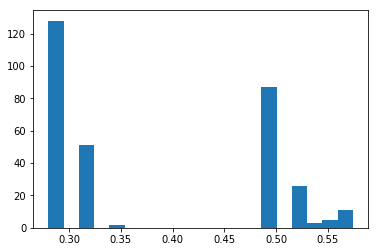

In [183]:
train_marginals = gen_model.marginals(L_train)
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.show()

In [184]:
gen_model.learned_lf_stats()

,Accuracy,Coverage,Precision,Recall
0,0.531854,0.6671,0.528324,0.354471
1,0.534181,0.6685,0.533333,0.358472
2,0.706449,0.6854,0.705049,0.477696
3,0.540710,0.6706,0.539514,0.355071
4,0.549662,0.6655,0.551807,0.369674
5,0.534894,0.6663,0.530594,0.353871


In [185]:
L_dev = labeler.apply_existing(split=1)


Clearing existing...
Running UDF...
[========================================] 100%



### Save noisy labels to database

In [186]:
from snorkel.annotations import save_marginals
%time save_marginals(session, L_train, train_marginals)

Saved 313 marginals
CPU times: user 328 ms, sys: 7.61 ms, total: 336 ms
Wall time: 376 ms
